# 1. Data Preprocessing

In [1]:
# Required Libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import StandardScaler
import spacy

# Load Dataset
df = pd.read_csv(r"C:\Users\Ankita Singh\Ingredient-Weight-Estimation-Model\dataset.csv")

# Display the first few rows
print(df.head())

# Drop any rows with missing values
df_cleaned = df.dropna()

# Basic statistics of the dataset
print(df_cleaned.describe())

# Display the data types of the DataFrame
print(df_cleaned.dtypes)

# Dropping columns with non-numeric data for now
# Assuming 'NDB_No' and 'Descrip' are the only non-numeric columns
df_cleaned = df_cleaned.drop(['NDB_No', 'Descrip'], axis=1)

# Convert the 'Magnesium_mg' and 'VitE_mg' columns to numeric, forcing errors to NaN
df_cleaned['Magnesium_mg'] = pd.to_numeric(df_cleaned['Magnesium_mg'], errors='coerce')
df_cleaned['VitE_mg'] = pd.to_numeric(df_cleaned['VitE_mg'], errors='coerce')

# Check if all columns are numeric after cleaning
print(df_cleaned.dtypes)

# Drop any rows with missing values again after conversion
df_cleaned = df_cleaned.dropna()

# Scaling numerical data for better model performance
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_cleaned)

# Convert back to a DataFrame
df_scaled = pd.DataFrame(df_scaled, columns=df_cleaned.columns)

# Display the scaled data
print(df_scaled.head())


  NDB_No                Descrip  Energy_kcal  Protein_g  Saturated_fats_g  \
0   1001       butter with salt        717.0       0.85            51.368   
1   1002  butter whipped w salt        718.0       0.49            45.390   
2   1003   butter oil anhydrous        876.0       0.28            61.924   
3   1004            cheese blue        353.0      21.40            18.669   
4   1005           cheese brick        371.0      23.24            18.764   

   Fat_g  Carb_g  Fiber_g  Sugar_g  Calcium_mg  ...  VitC_mg Thiamin_mg  \
0  81.11    0.06      0.0     0.06        24.0  ...      0.0      0.005   
1  78.30    2.87      0.0     0.06        23.0  ...      0.0      0.007   
2  99.48    0.00      0.0     0.00         4.0  ...      0.0      0.001   
3  28.74    2.34      0.0     0.50       528.0  ...      0.0      0.029   
4  29.68    2.79      0.0     0.51       674.0  ...      0.0      0.014   

   Riboflavin_mg  Niacin_mg  VitB6_mg  Folate_mcg  VitB12_mcg  VitA_mcg  \
0          

# 2. Feature Engineering

In [6]:
# Add back the 'Descrip' column for NLP processing
df_cleaned['Descrip'] = df['Descrip']

# Load pre-trained spaCy NLP model (assuming 'en_core_web_sm' is installed)
nlp = spacy.load('en_core_web_sm')

# Extract features from the 'Descrip' column using NLP
def extract_ingredients(description):
    doc = nlp(description)
    ingredients = [token.text for token in doc if token.pos_ in ['NOUN', 'PROPN']]
    return ' '.join(ingredients)

# Apply the function to extract ingredients
df_cleaned['Ingredients'] = df_cleaned['Descrip'].apply(extract_ingredients)

# Create dummy variables for ingredients (basic example, might need tuning)
df_cleaned = pd.get_dummies(df_cleaned, columns=['Ingredients'], drop_first=True)

# Drop the original 'Descrip' column after feature extraction
df_cleaned = df_cleaned.drop(['Descrip'], axis=1)



In [7]:
# Split the dataset into features (X) and target (y)
X = df_cleaned.drop(['Fat_g'], axis=1)  # Features
y = df_cleaned['Fat_g']  # Target

# Split the data into train and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [8]:
problematic_rows = X_train[X_train.applymap(lambda x: isinstance(x, str) and ' ' in x)]
print(problematic_rows)


C:\Users\Ankita Singh\AppData\Local\Temp\ipykernel_21560\28422165.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  problematic_rows = X_train[X_train.applymap(lambda x: isinstance(x, str) and ' ' in x)]


      Energy_kcal  Protein_g  Saturated_fats_g  Carb_g  Fiber_g  Sugar_g  \
503           NaN        NaN               NaN     NaN      NaN      NaN   
5813          NaN        NaN               NaN     NaN      NaN      NaN   
274           NaN        NaN               NaN     NaN      NaN      NaN   
1345          NaN        NaN               NaN     NaN      NaN      NaN   
5057          NaN        NaN               NaN     NaN      NaN      NaN   
...           ...        ...               ...     ...      ...      ...   
5734          NaN        NaN               NaN     NaN      NaN      NaN   
5191          NaN        NaN               NaN     NaN      NaN      NaN   
5390          NaN        NaN               NaN     NaN      NaN      NaN   
860           NaN        NaN               NaN     NaN      NaN      NaN   
7270          NaN        NaN               NaN     NaN      NaN      NaN   

      Calcium_mg  Iron_mg  Magnesium_mg  Phosphorus_mg  ...  \
503          NaN      Na

In [9]:
def clean_data(value):
    if isinstance(value, str):
        if ' ' in value:
            # Example: Replace the space with a comma, or take the first number
            return float(value.split()[0])  # Or some other strategy to clean
    return value

X_train = X_train.applymap(clean_data)
X_test = X_test.applymap(clean_data)


C:\Users\Ankita Singh\AppData\Local\Temp\ipykernel_21560\896601964.py:8: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_train = X_train.applymap(clean_data)
C:\Users\Ankita Singh\AppData\Local\Temp\ipykernel_21560\896601964.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  X_test = X_test.applymap(clean_data)


In [10]:
X_train = X_train.apply(pd.to_numeric, errors='coerce')  # Convert everything to numeric, set invalid entries as NaN
X_train.fillna(X_train.median(), inplace=True)  # Replace NaN values with median


# 3. Model Training

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Similarly for X_test (important step for consistency)
X_test = X_test.apply(pd.to_numeric, errors='coerce')
X_test.fillna(X_test.median(), inplace=True)

# Initialize the RandomForestRegressor model
model = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model on the training data
model.fit(X_train, y_train)

# Predict the target on the test data
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

# Print the evaluation metrics
print(f"Mean Squared Error: {mse}")
print(f"R-squared: {r2}")


Mean Squared Error: 2.5230430733870093
R-squared: 0.9897584482479324


 ## Model Validation (K-Fold Cross-Validation)

In [12]:
from sklearn.model_selection import cross_val_score

# Perform K-Fold Cross-Validation
k = 5  # Number of folds
cv_scores = cross_val_score(model, X, y, cv=k, scoring='neg_mean_squared_error')

# Convert scores to positive values and calculate the average
cv_mse = -cv_scores.mean()
print(f'Average Cross-Validated MSE: {cv_mse}')


Average Cross-Validated MSE: 4.192019183709256


## Error Analysis

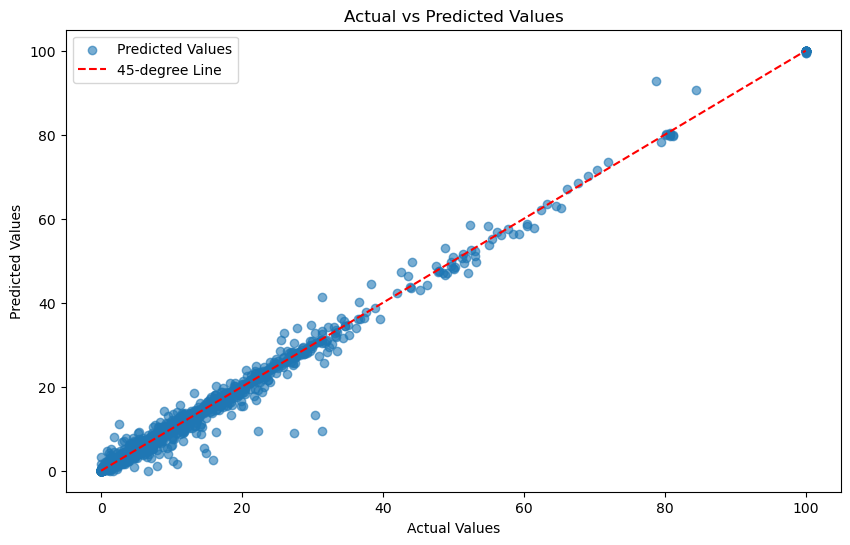

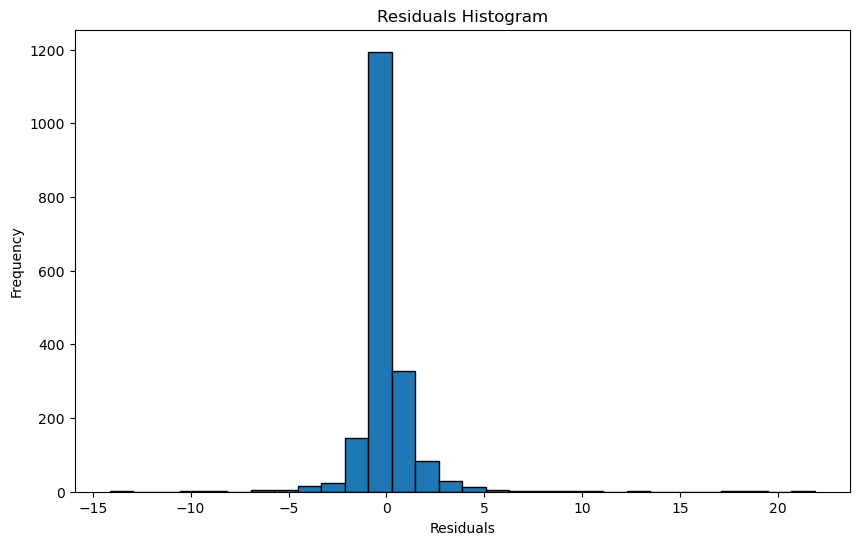

In [13]:
import matplotlib.pyplot as plt

# Compare actual vs predicted values
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.6, label='Predicted Values')  # Blue dots
plt.plot([y.min(), y.max()], [y.min(), y.max()], 'r--', label='45-degree Line')  # Red line
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs Predicted Values')
plt.legend()  # Add legend
plt.show()

# Residual analysis
residuals = y_test - y_pred
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Residuals Histogram')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()
